In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import SVR
# from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.Regressor import StackingCVRegressor #
from mlxtend.classifier import StackingCVClassifier
import xgboost as xgb

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [5]:
!pip install xgboost

  Using cached xgboost-1.1.1-py3-none-win_amd64.whl (54.4 MB)


In [8]:
df = pd.read_csv('data.csv')
df.head()

,IDENTIF,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,MATERIAL,SPAN,REL-L,TYPE
0,E1,M,3.0,CRAFTS,HIGHWAY,NaN,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
1,E2,A,25.0,CRAFTS,HIGHWAY,MEDIUM,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
2,E3,A,39.0,CRAFTS,AQUEDUCT,NaN,1.0,N,THROUGH,WOOD,NaN,S,WOOD
3,E5,A,29.0,CRAFTS,HIGHWAY,MEDIUM,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
4,E6,M,23.0,CRAFTS,HIGHWAY,NaN,2.0,N,THROUGH,WOOD,NaN,S,WOOD


In [9]:

# Drop Colums a & b from dfObj in place
df.drop([106 , 107], inplace=True)

In [10]:
df['IDENTIF']=df['IDENTIF'].astype('category')
# df['IDENTIF']=df['IDENTIF'].astype('category')
df = df[df.TYPE!= 'NIL']

In [11]:
X = df.drop('TYPE', axis=1)
y = df[['TYPE']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)
X_train.head()


,IDENTIF,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,MATERIAL,SPAN,REL-L
27,E29,A,26.0,EMERGING,HIGHWAY,MEDIUM,2.0,G,THROUGH,STEEL,MEDIUM,NaN
16,E18,A,28.0,CRAFTS,RR,MEDIUM,2.0,N,THROUGH,IRON,SHORT,S
49,E94,M,13.0,MATURE,RR,NaN,2.0,G,THROUGH,STEEL,LONG,F
6,E8,A,28.0,CRAFTS,AQUEDUCT,MEDIUM,1.0,N,THROUGH,IRON,SHORT,S
87,E108,A,39.5,MODERN,HIGHWAY,MEDIUM,4.0,G,DECK,STEEL,MEDIUM,S-F


SIMPLE-T    44
WOOD        16
ARCH        13
CANTILEV    11
SUSPEN      11
CONT-T      10
Name: TYPE, dtype: int64

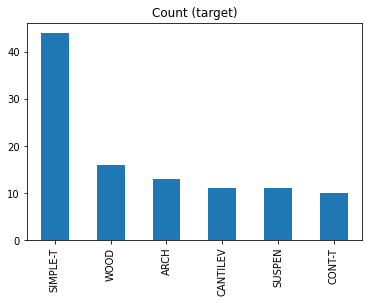

In [12]:
df.TYPE.value_counts().plot(kind='bar', title='Count (target)');
df.TYPE.value_counts()
# df_test_over.y.value_counts().plot(kind='bar', title='Count (target)');
# df.drop
# 

In [13]:
df.TYPE.value_counts()

SIMPLE-T    44
WOOD        16
ARCH        13
CANTILEV    11
SUSPEN      11
CONT-T      10
Name: TYPE, dtype: int64

In [14]:
df.shape

(105, 13)

In [15]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)


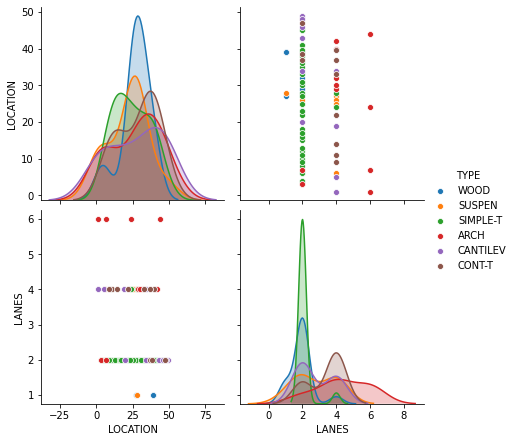

In [16]:
import seaborn as sns
sns.pairplot(df, hue='TYPE', size=3)

In [17]:
df.dtypes

IDENTIF     category
RIVER         object
LOCATION     float64
ERECTED       object
PURPOSE       object
LENGTH        object
LANES        float64
CLEAR-G       object
T-OR-D        object
MATERIAL      object
SPAN          object
REL-L         object
TYPE          object
dtype: object

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df['TYPE'] = LabelEncoder().fit_transform(df['TYPE'])

In [19]:
df['TYPE'].value_counts()

3    44
5    16
0    13
4    11
1    11
2    10
Name: TYPE, dtype: int64

In [20]:
n_estimators = [50,100,300,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,15,20]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [106]:
# num_indices1 = list(X.iloc[:,np.r_[0:94,95,97,100:120,121:123]].columns.values)
# cat_indices1 = list(X.iloc[:,np.r_[94,96,98,99,120]].columns.values)
from sklearn.pipeline import FeatureUnion, Pipeline

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

num_cols_ind = []
for key in num_features:
    ind = X_train.columns.get_loc(key)
    num_cols_ind.append(ind)
    
cat_cols_ind = []
for key in cat_features:
    ind = X_train.columns.get_loc(key)
    cat_cols_ind.append(ind)


# print(len(num_indices1))
# print(len(cat_indices1))

# cat_indices = [94, 96, 98, 99, 120]

from imblearn.pipeline import make_pipeline

pipeline=Pipeline(steps= [
    # Categorical features
    ('feature_processing', FeatureUnion(transformer_list = [ ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('categorical', cat_features),

            #numeric
            ('numeric', Pipeline(steps = [
                ('imputer', SimpleImputer(strategy='median')),
#                 ('select', num_features),
                ('scale', StandardScaler())
                        ]))
        ])),
    ('randomforestclassifier', model)
    ]
)
pipeline_with_resampling = make_pipeline(SMOTENC(categorical_features=cat_indices), pipeline)

params = {
               'pipeline__randomforestclassifier__n_estimators': n_estimators,  #randomforestregressor__bootstrap
               'pipeline__randomforestclassifier__max_features': max_features,
               'pipeline__randomforestclassifier__max_depth': max_depth,
               'pipeline__randomforestclassifier__min_samples_split': min_samples_split,
               'pipeline__randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'pipeline__randomforestclassifier__bootstrap': bootstrap,
#               "xgbclassifier__n_estimators": [10, 50, 100, 500],
#                 "xgbclassifier__learning_rate": [0.1, 0.5, 1],
         }

grid = GridSearchCV(
    verbose=5,
    estimator=pipeline_with_resampling, 
    param_grid=params, 
    cv=3,
    refit=True
)

 

grid.fit(X_train, y_train)          

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 
from imblearn.pipeline import make_pipeline
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

cat_cols_ind = []
for key in cat_features:
    ind = X_train.columns.get_loc(key)
    cat_cols_ind.append(ind)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

smote_nc = SMOTENC(categorical_features=cat_cols_ind, random_state=42)


# oversample = SMOTE()
# X, y = SMOTE().fit_resample(X, y)

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

model = RandomForestClassifier(n_jobs = -1, random_state = 1000)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

# preprocess = make_column_transformer((numeric_transformer num_features),
#                                     categorical_transformer,cat_features))

# smote_nc = 
# SMOTENC(categorical_features=cat_features, random_state=0)
# steps = [('preprocess',preprocessor),('randomforestclassifier',model)]

steps = [('preprocess',preprocessor),
         ('randomforestclassifier',model)]

pipe = Pipeline(steps = steps) 
pipe_stack = make_pipeline(SMOTENC(categorical_features=cat_cols_ind), pipe)



params = {
               'pipeline__randomforestclassifier__n_estimators': n_estimators,  #randomforestregressor__bootstrap
               'pipeline__randomforestclassifier__max_features': max_features,
               'pipeline__randomforestclassifier__max_depth': max_depth,
               'pipeline__randomforestclassifier__min_samples_split': min_samples_split,
               'pipeline__randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'pipeline__randomforestclassifier__bootstrap': bootstrap,
#               "xgbclassifier__n_estimators": [10, 50, 100, 500],
#                 "xgbclassifier__learning_rate": [0.1, 0.5, 1],
         }

grid = GridSearchCV(
    verbose=5,
    estimator=pipe_stack, 
    param_grid=params, 
    cv=3,
    refit=True
)

 

grid.fit(X_train, y_train)                                    
                                    
# Pipeline([('preprocessor', preprocess),('stackingcvregressor',stacking_model)])

# resampled_training_inputs, resampled_training_outputs_labels = sm.fit_resample(X_train, y_train)
# resampled_training_outputs = [one_hot(c,z) for c in resampled_training_outputs_labels]

In [165]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object','category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model = RandomForestClassifier(n_jobs = -1, random_state = 1000, class_weight = "balanced_subsample")

pipe_stack = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

pipe_stack.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['LOCATION', 'LANES'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                     

In [30]:
# Split Train and Test
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
# Set variables
from fancyimpute import KNN
from fancyimpute import IterativeImputer

# from sklearn.experimental import enable_iterative_imputer, enable_hist_gradient_boosting
# from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object','category']).columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
# imputer_numerical = SimpleImputer(add_indicator=True, verbose=1, strategy='median')
imputer_numerical =  IterativeImputer(random_state=0)
# imputer_numerical =  KNN(2)
imputer_categorical = SimpleImputer(strategy='most_frequent',verbose = 1,add_indicator=True)

scaler = StandardScaler()

model = RandomForestClassifier(n_jobs = -1, random_state = 1000, class_weight = "balanced_subsample")

preprocessing = make_column_transformer(
(make_pipeline(imputer_numerical,scaler),num_features)
,(make_pipeline(imputer_categorical,ohe),cat_features)
,remainder='passthrough')
# Make pipeline
pipe = make_pipeline(preprocessing, model)
# Fit model
pipe.fit(X_train, y_train.values.ravel())
print("Best score : %f" % pipe.score(X_test, y_test.values.ravel()))

Best score : 0.685714


In [166]:
print(pipe_stack.predict(X_test))
print("model score: %.3f" % pipe_stack.score(X_test, y_test))

['SIMPLE-T' 'CANTILEV' 'SIMPLE-T' 'SIMPLE-T' 'WOOD' 'SIMPLE-T' 'SIMPLE-T'
 'SIMPLE-T' 'SIMPLE-T' 'CONT-T' 'SIMPLE-T' 'CANTILEV' 'CONT-T' 'SIMPLE-T'
 'SUSPEN' 'SIMPLE-T' 'WOOD' 'WOOD' 'ARCH' 'CONT-T' 'SIMPLE-T' 'WOOD'
 'SIMPLE-T' 'SIMPLE-T' 'ARCH' 'SIMPLE-T' 'SIMPLE-T' 'SIMPLE-T' 'SIMPLE-T'
 'SIMPLE-T' 'WOOD' 'SIMPLE-T' 'WOOD' 'SIMPLE-T' 'SIMPLE-T']
model score: 0.686


In [143]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 
# from imblearn.pipeline import make_pipeline
# from sklearn.experimental import enable_iterative_imputer, enable_hist_gradient_boosting
# from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object','category']).columns

cat_cols_ind = []
for key in cat_features:
    ind = X_train.columns.get_loc(key)
    cat_cols_ind.append(ind)

# smote_nc = SMOTENC(categorical_features=cat_cols_ind, random_state=42,k_neighbors=2)


# oversample = SMOTE()
# X, y = SMOTE().fit_resample(X, y)

model = RandomForestClassifier(n_jobs = -1, random_state = 1000, class_weight = "balanced_subsample")

# preprocessor1 = make_column_transformer(
#         (SimpleImputer(strategy='median', axis = 0), num_features),
#         (StandardScaler(), num_features),
#     (SimpleImputer(strategy='constant', fill_value='missing', axis = 0), cat_features),
#     (OneHotEncoder(handle_unknown='ignore'), cat_features),
#     remainder = 'passthrough')

preprocess = make_column_transformer( (SimpleImputer(strategy='median'), num_features), 
                                    (SimpleImputer(strategy='constant', fill_value='missing'), cat_features),
                                    (StandardScaler(), num_features),
                                    (OneHotEncoder(handle_unknown='ignore'),cat_features))

# stacking_model = StackingCVRegressor(regressors=(rf,lr), 
#                             meta_regressor=lr,
#                             random_state=42)

pipe_stack = Pipeline([('preprocessor', preprocess),('rf',model)])
    
# pipe_stack = make_pipeline(preprocessor1,model)

pipe_stack.fit(X_train, y_train)

# params = {
#                'pipeline__randomforestclassifier__n_estimators': n_estimators,  #randomforestregressor__bootstrap
#                'pipeline__randomforestclassifier__max_features': max_features,
#                'pipeline__randomforestclassifier__max_depth': max_depth,
#                'pipeline__randomforestclassifier__min_samples_split': min_samples_split,
#                'pipeline__randomforestclassifier__min_samples_leaf': min_samples_leaf,
#                'pipeline__randomforestclassifier__bootstrap': bootstrap,}
# #               "xgbclassifier__n_estimators": [10, 50, 100, 500],
# #                 "xgbclassifier__learning_rate": [0.1, 0.5, 1],
# #          }

# grid = GridSearchCV( verbose=5, estimator=pipe_stack, param_grid=params, cv=3, refit=True )

 

# grid.fit(X_train, y_train)                                    
                                    
# Pipeline([('preprocessor', preprocess),('stackingcvregressor',stacking_model)])

# resampled_training_inputs, resampled_training_outputs_labels = sm.fit_resample(X_train, y_train)
# resampled_training_outputs = [one_hot(c,z) for c in resampled_training_outputs_labels]

ValueError: Input contains NaN

In [38]:
X_train


,IDENTIF,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,MATERIAL,SPAN,REL-L
28,E28,M,3.0,EMERGING,HIGHWAY,MEDIUM,2.0,G,THROUGH,STEEL,MEDIUM,S
40,E41,M,11.0,MATURE,HIGHWAY,NaN,2.0,G,THROUGH,IRON,MEDIUM,F
5,E7,A,27.0,CRAFTS,HIGHWAY,SHORT,2.0,N,THROUGH,WOOD,MEDIUM,S
53,E51,M,6.0,MATURE,RR,MEDIUM,2.0,G,THROUGH,STEEL,MEDIUM,F
107,E109,A,28.0,MODERN,HIGHWAY,NaN,NaN,G,NaN,NaN,NaN,F
39,E40,M,22.0,MATURE,HIGHWAY,NaN,2.0,G,THROUGH,STEEL,MEDIUM,F
35,E38,M,17.0,MATURE,HIGHWAY,NaN,2.0,G,THROUGH,IRON,MEDIUM,F
16,E18,A,28.0,CRAFTS,RR,MEDIUM,2.0,N,THROUGH,IRON,SHORT,S
78,E75,A,30.0,MATURE,HIGHWAY,LONG,4.0,G,DECK,STEEL,MEDIUM,F
34,E35,A,27.0,MATURE,HIGHWAY,MEDIUM,2.0,G,THROUGH,STEEL,MEDIUM,F


In [78]:
print ("score = %3.2f" %(grid.best_score_))
print (grid.best_params_)

score = 0.62
{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 50}


In [79]:
grid.predict(X_test)

array(['ARCH', 'WOOD', 'WOOD', 'SIMPLE-T', 'CONT-T', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'CONT-T', 'WOOD', 'SIMPLE-T', 'SIMPLE-T',
       'WOOD', 'SIMPLE-T', 'WOOD', 'SIMPLE-T', 'SIMPLE-T', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'WOOD', 'SUSPEN', 'ARCH', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'SIMPLE-T', 'SUSPEN', 'SIMPLE-T', 'SUSPEN',
       'SIMPLE-T', 'SIMPLE-T', 'WOOD', 'SIMPLE-T', 'CONT-T'], dtype=object)

In [69]:
pipe_stack.predict(X_test)

array(['ARCH', 'WOOD', 'WOOD', 'SIMPLE-T', 'CONT-T', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'SIMPLE-T', 'WOOD', 'SIMPLE-T', 'SIMPLE-T',
       'WOOD', 'CANTILEV', 'WOOD', 'SIMPLE-T', 'SIMPLE-T', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'WOOD', 'SUSPEN', 'ARCH', 'SIMPLE-T',
       'SIMPLE-T', 'SIMPLE-T', 'SIMPLE-T', 'SUSPEN', 'SIMPLE-T', 'SUSPEN',
       'SIMPLE-T', 'SIMPLE-T', 'WOOD', 'SIMPLE-T', 'CONT-T'], dtype=object)

In [70]:
print("model score: %.3f" % pipe_stack.score(X_test, y_test))
print(classification_report(y_test, predictions))
print(f1_score(y_true, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
auc = roc_auc_score(y_test, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

model score: 0.829
